# Hail Detection Animation

This code uses the csu_radartools package and fuzzy logic to create an animation of KDP.

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import pyart
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from time import time
import netCDF4
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from datetime import datetime
from dateutil import tz
from skewt import SkewT
from glob import glob
from botocore.handlers import disable_signing
from matplotlib.animation import FuncAnimation
import cartopy.io.shapereader as shpreader
import csu_radartools
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals) 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Use Amazon to download and obtain radar scans:

In [ ]:
# Obtaining radar scans...
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    for key in keys:
        if 'MDM' in key:
            keys.remove(key)
    print(keys)
    return aws_radar, keys

In [ ]:
aws_radar, keys = get_radar_scan(station='KLOT', date='2019/05/27', key_index=-400) 
out_path_dir = 'home/amedendorp/Desktop/april182013'

In [ ]:
nk = keys[175:210] #:210
nk

In [ ]:
localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(nk[0], localfile.name)
radar = pyart.io.read(localfile.name)
radar.fields.keys()

In [ ]:
t = netCDF4.num2date(radar.time['data'][0],
                     radar.time['units'])
t

In [ ]:
%%time
for i in nk:
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(i, localfile.name)
    radar = pyart.io.read(localfile.name)
    
    dz = radar.fields['reflectivity']['data']
    dr = radar.fields['differential_reflectivity']['data']
    kd = radar.fields['differential_phase']['data']
    rh = radar.fields['cross_correlation_ratio']['data']
    fill_value = -32768
    dzN = radar.fields['reflectivity']['data'].filled(fill_value=fill_value)
    dpN = radar.fields['differential_phase']['data'].filled(fill_value=fill_value)
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    
    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
        dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
    
    def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
        """
        Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
        make the new field masked the same as reflectivity.
        """
        fill_value = -32768
        masked_field = np.ma.asanyarray(field)
        gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_below(dz_field, 20)
        masked_field.mask = masked_field == fill_value
        if hasattr(radar.fields[dz_field]['data'], 'mask'):
            setattr(masked_field, 'mask', 
                    np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
            fill_value = radar.fields[dz_field]['_FillValue']
        field_dict = {'data': masked_field,
                      'units': units,
                      'long_name': long_name,
                      'standard_name': standard_name,
                      '_FillValue': fill_value}
        radar.add_field(field_name, field_dict, replace_existing=True)
        return radar
    
    radarN = add_field_to_radar_object(kdN, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase',
                                   dz_field='reflectivity')
    radarN = add_field_to_radar_object(fdN, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase',
                                   dz_field='reflectivity')
    radarN = add_field_to_radar_object(sdN, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase',
                                   dz_field='reflectivity' )
    # Create rainfall rate field
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radarN.fields['KDP']['data'][:, -10:] = np.ma.masked

    gatefilter = pyart.filters.GateFilter(radarN)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('KDP')
    grid = pyart.map.grid_from_radars(
            (radarN, ), grid_shape=(16, 300, 300),
            grid_limits=((0, 15000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['KDP'], weighting_function='Barnes2',
            gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=500., gatefilters=(gatefilter, ))
    name = os.path.join('/home/amedendorp/Desktop/MESH/KDP_grid_' + str(i[-23:]) + '.nc')
    grid.write(name)
    del radarN, radar, grid

In [2]:
reader = shpreader.Reader('/home/amedendorp/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

2019-05-27 17:41:27.973000
2019-05-27 17:41:27.973000
2019-05-27 17:47:20.429000
2019-05-27 17:53:11.744000
2019-05-27 17:58:59.269000
2019-05-27 18:04:45.995000
2019-05-27 18:10:38.871000
2019-05-27 18:16:15.015000
2019-05-27 18:21:52.203000
2019-05-27 18:27:31.288000
2019-05-27 18:32:45.044000
2019-05-27 18:37:44.662000
2019-05-27 18:42:50.639000
2019-05-27 18:47:50.278000
2019-05-27 18:52:57.119000
2019-05-27 18:58:02.637000
2019-05-27 19:03:08.745000
2019-05-27 19:08:15.174000
2019-05-27 19:13:15.230000
2019-05-27 19:18:13.709000
2019-05-27 19:23:13.753000
2019-05-27 19:28:13.415000
2019-05-27 19:33:43.537000
2019-05-27 19:38:42.985000
2019-05-27 19:43:42.072000
2019-05-27 19:49:11.617000
2019-05-27 19:54:57.365000
2019-05-27 20:00:43.523000
2019-05-27 20:06:28.910000
2019-05-27 20:12:15.303000
2019-05-27 20:18:02.746000
2019-05-27 20:23:50.087000
2019-05-27 20:29:37.443000
2019-05-27 20:35:23.932000
2019-05-27 20:41:09.403000


<function matplotlib.pyplot.close(fig=None)>

2019-05-27 17:41:27.973000


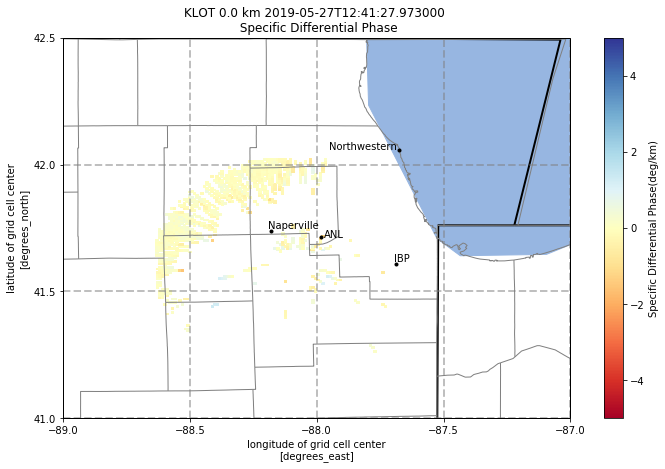

In [3]:
# This code was created using a modified version of pyART. The only thing that will change versus default
# pyART is the thickness and color of the lat and lon lines, and the county and state outlines.
def rr_animation(nframe): 
    plt.clf()
    files = glob('/home/amedendorp/Desktop/MESH/KDP_grid_KLOT*')
    files.sort()
    nfile = files[nframe]
    radar = pyart.io.read_grid(nfile)

    # Converting the default UTC time to local time...
    # Converts to 24-hour time. No AM or PM.
    utc = netCDF4.num2date(radar.time['data'][0],
                       radar.time['units'])
    print(str(utc))
    z = datetime.strptime(str(utc), '%Y-%m-%d %H:%M:%S.%f')
  
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    z = z.replace(tzinfo=from_zone)
    central = z.astimezone(to_zone)
    t = datetime.strftime(central, '%Y-%m-%dT%H:%M:%S.%f')

    title = ('KLOT ' + str(radar.z['data'][0]/1000) + ' km ' + t + ' \n'
             + ' Specific Differential Phase')

    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    
    # Plot site locations...
    ANL_lon, ANL_lat = -87.981810, 41.713969 
    NW_lon, NW_lat = -87.675885, 42.057888
    Naperville_lon, Naperville_lat = -88.181798, 41.738107
    IBP_lon, IBP_lat = -87.687151, 41.606367

    plt.plot([ANL_lon], [ANL_lat], color='black', marker= '.')
    plt.plot([NW_lon], [NW_lat], color='black', marker= '.')
    plt.plot([Naperville_lon], [Naperville_lat], color='black', marker= '.')
    plt.plot([IBP_lon], [IBP_lat], color='black', marker= '.')

    # Plot names of sites:
    plt.text(ANL_lon + 0.01, ANL_lat - 0., 'ANL', horizontalalignment='left')
    plt.text(NW_lon - 0.01, NW_lat - 0, 'Northwestern', horizontalalignment='right')
    plt.text(Naperville_lon - 0.01, Naperville_lat + 0.01, 'Naperville', horizontalalignment='left')
    plt.text(IBP_lon - 0.01, IBP_lat + 0.01, 'IBP', horizontalalignment='left')
    
    display = pyart.graph.GridMapDisplay(radar)
    display.plot_grid('KDP', level= 0, lat_lines=np.arange(41, 43, .5), 
                       lon_lines=np.arange(-89, -86.5, .5), cmap='RdYlBu', vmax=5, vmin=-5,
                       projection=projection, title=title, embelish=True) 
    

    plt.rcParams.update({'axes.titlesize': '18'})
    ax.tick_params(labelsize=14) 
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['font.size']=16
    plt.rcParams['ytick.labelsize']=14
    plt.ylabel("latitude", fontsize = 16)
    plt.xlabel("longitude", fontsize = 16)
    
    del radar, display
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    ax.add_feature(cfeature.LAKES, zorder=.5)
    
fig = plt.figure(figsize=[12,7])

# Match the frames to the amount of grids
sat_anim = FuncAnimation(fig, rr_animation, frames=34)
sat_anim.save('/home/amedendorp/Desktop/csuanimtest.gif',
              writer='imagemagick', fps=3)
plt.close